In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import plotly.express as px
import datetime
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
df_indicator = pd.read_csv("data/nchs_covid_indicators_of_anxiety_depression.csv")
df_indicator["Time Period End Date"] = df_indicator["Time Period End Date"].apply(pd.to_datetime)

In [3]:
df_indicator = df_indicator.drop(columns=["Quartile Range"])
df_indicator.head()

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1,"Apr 23 - May 5, 2020",04/23/2020,2020-05-05,23.5,22.7,24.3,22.7 - 24.3
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,2020-05-05,32.7,30.2,35.2,30.2 - 35.2
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,2020-05-05,25.7,24.1,27.3,24.1 - 27.3
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,2020-05-05,24.8,23.3,26.2,23.3 - 26.2
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,2020-05-05,23.2,21.5,25.0,21.5 - 25.0


In [4]:
df_indicator["Indicator"].value_counts()

Symptoms of Depressive Disorder                        3228
Symptoms of Anxiety Disorder                           3228
Symptoms of Anxiety Disorder or Depressive Disorder    3228
Name: Indicator, dtype: int64

In [5]:
df_indicator = df_indicator.query("Indicator == 'Symptoms of Anxiety Disorder or Depressive Disorder'")

In [6]:
df_indicator["KEY"] = (df_indicator["Group"] +
                       ", "+df_indicator["State"] +
                       ", " + df_indicator["Subgroup"] +
                       ", " + df_indicator["Time Period Label"]
                       )

In [7]:
df_access = pd.read_csv("data/nchs_covid_mental_health_care.csv")
df_access["Time Period End Date"] = df_access["Time Period End Date"].apply(pd.to_datetime)

In [8]:
df_access = df_access.drop(columns=["Quartile Range", "Suppression Flag"])
df_access.head()

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,LowCI,HighCI,Confidence Interval
0,Took Prescription Medication for Mental Health...,National Estimate,United States,United States,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,2020-08-31,19.4,19.0,19.8,19.0 - 19.8
1,Took Prescription Medication for Mental Health...,By Age,United States,18 - 29 years,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,2020-08-31,18.7,17.2,20.3,17.2 - 20.3
2,Took Prescription Medication for Mental Health...,By Age,United States,30 - 39 years,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,2020-08-31,18.3,17.3,19.2,17.3 - 19.2
3,Took Prescription Medication for Mental Health...,By Age,United States,40 - 49 years,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,2020-08-31,20.4,19.5,21.3,19.5 - 21.3
4,Took Prescription Medication for Mental Health...,By Age,United States,50 - 59 years,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,2020-08-31,21.2,20.2,22.2,20.2 - 22.2


In [9]:
df_access["Indicator"].value_counts()

Took Prescription Medication for Mental Health, Last 4 Weeks                                          2441
Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks    2441
Received Counseling or Therapy, Last 4 Weeks                                                          2441
Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks                                         2441
Name: Indicator, dtype: int64

In [10]:
df_access = df_access.query(
    "Indicator == 'Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks'")

In [11]:
df_access["KEY"] = (df_access["Group"] +
                    ", "+df_access["State"] +
                    ", " + df_access["Subgroup"] +
                    ", " + df_access["Time Period Label"]
                    )

In [12]:
df_merged = pd.merge(df_access, df_indicator, left_on="KEY", right_on="KEY", how="inner")

In [13]:
df_merged = df_merged.drop(columns=['Group_y', 'State_y',
       'Subgroup_y', 'Phase_y', 'Time Period_y', 'Time Period Label_y',
       'Time Period Start Date_y', 'Time Period End Date_y'])

In [14]:
df_merged = df_merged.rename(columns={"Value_x": "Treated (Meds or Therapy)", "Value_y": "Experienced Anxiety/Depression Symptoms"})

In [18]:
fig = px.line(df_merged.query("State_x == 'Florida'"),
              x="Time Period End Date_x",
              y=["Treated (Meds or Therapy)", "Experienced Anxiety/Depression Symptoms"],
              title="National Trend"); 
fig.show()

In [19]:
fig = px.line(df_merged.query("Group_x == 'National Estimate'"),
              x="Time Period End Date_x",
              y=["Treated (Meds or Therapy)", "Experienced Anxiety/Depression Symptoms"],
              title="National Trend"); 
fig.show()

In [194]:
coeffs = []
B = 1000
for i in range(B):
    corr_ = (df_merged[["Treated (Meds or Therapy)", "Experienced Anxiety/Depression Symptoms"]]
             .sample(1000,
             replace=True)
             .corr()
             .loc["Treated (Meds or Therapy)", "Experienced Anxiety/Depression Symptoms"]
             )
    coeffs.append(corr_)

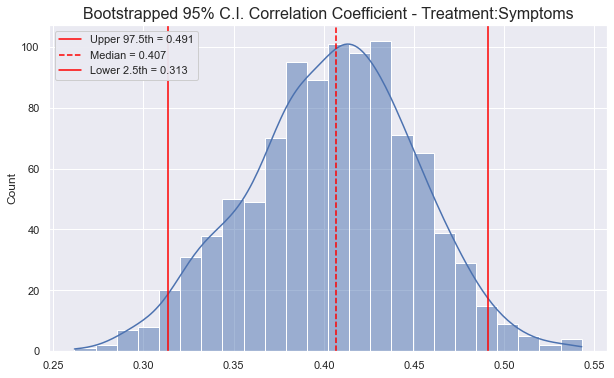

In [230]:
plt.figure(figsize=(10, 6))
sns.histplot(data=coeffs, kde=True)
plt.axvline(np.percentile(coeffs, 97.5), c="red", linestyle="-",
            label=f"Upper 97.5th = {round(np.percentile(coeffs, 97.5), 3)}")
plt.axvline(np.median(coeffs), c="red", linestyle="--",
            label=f"Median = {round(np.median(coeffs), 3)}")
plt.axvline(np.percentile(coeffs, 2.5), c="red", linestyle="-",
            label=f"Lower 2.5th = {round(np.percentile(coeffs, 2.5), 3)}")
plt.title("Bootstrapped 95% C.I. Correlation Coefficient - Treatment:Symptoms").set_fontsize(16)
plt.legend(loc="upper left", framealpha=.95);